In [81]:
!pip install -q xlearn

In [82]:
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix, csc_matrix
import pandas as pd
import datetime as dt
import xlearn as xl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from typing import Optional, List

# Метрики
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score

# Sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML

### Loading Data

In [83]:
def data_preprocess(data):
    data['date_time'] = pd.to_datetime(data['date_time'])
    # Удаляем колонки, которые по условию не нужны для 2го ДЗ
    data = data.drop(['banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'], axis=1)
    return data

In [84]:
data = pd.read_csv('../data/data.csv')
data = data_preprocess(data)
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30,0,0,5664530014561852622,0,0,0,1,1
1,2021-09-26 22:54:49,1,1,5186611064559013950,0,0,1,1,1
2,2021-09-26 23:57:20,2,2,2215519569292448030,3,0,0,1,1
3,2021-09-27 00:04:30,3,3,6262169206735077204,0,1,1,1,1
4,2021-09-27 00:06:21,4,4,4778985830203613115,0,1,0,1,1


### EDA

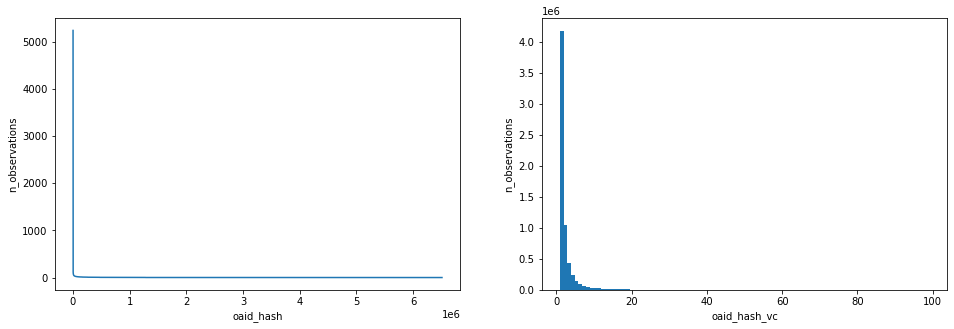

* Кол-во уникальных oaid_hash: 6510316 

* Топ 5 oaid_hash по кол-ву наблюдений:


,oaid_hash,n_observations
0,308174966294367527,5243
1,2890718152668627077,2511
2,2521895603443866206,2289
3,8212556321845734673,1974
4,3375698397737628939,1959


* Топ 5 по кол-ву наблюдений oaid_hash на пользователя


,oaid_hash_vc,n_observations
0,1,4182814
1,2,1049124
2,3,432171
3,4,233187
4,5,144499


In [85]:
oaid_hash_vc = pd.value_counts(data['oaid_hash'])

fig, axes = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)

oaid_hash_vc.reset_index(drop=True).plot(ax=axes[0])
axes[0].set_xlabel('oaid_hash')
axes[0].set_ylabel('n_observations')

oaid_hash_vc[oaid_hash_vc < 100].plot.hist(bins=100, ax=axes[1])
axes[1].set_xlabel('oaid_hash_vc')
axes[1].set_ylabel('n_observations')

plt.show()

print(f'* Кол-во уникальных oaid_hash: {len(pd.unique(data["oaid_hash"]))} \n')

print('* Топ 5 oaid_hash по кол-ву наблюдений:')
display(HTML(oaid_hash_vc[:5].reset_index().set_axis(['oaid_hash', 'n_observations'], axis=1).to_html()))

print('* Топ 5 по кол-ву наблюдений oaid_hash на пользователя')
display(HTML(pd.value_counts(oaid_hash_vc)[:5].reset_index().set_axis(['oaid_hash_vc', 'n_observations'], axis=1).to_html()))

#### Выводы по EDA

Единственная новая колонка - oaid_hash имеет большой 'хвост' из редких пользователей. Те пользователи, для которых во всем датасете только одно наблюдение (а таких 4182814 из 6510316 -- почти 2/3) не несут никакой полезной информации. Значит всех их можно объединить в одину категорию, значительно уменьшив число параметров модели. 

### Feature engineering

In [86]:
# Фичи, свзязанные с date_time
data['hour'] = data['date_time'].dt.hour
data['weekday'] = data['date_time'].dt.weekday

# Объединяем всех пользователей, для которых во всем датасете только одно наблюдение
n = 1
oaid_hash_n   = oaid_hash_vc[oaid_hash_vc > n].index
data['oaid_hash_n'] = data['oaid_hash'] * data['oaid_hash'].isin(oaid_hash_n)

# log campaign_clicks
data['campaign_clicks_eq_0'] = (data['campaign_clicks'] == 0).astype(int)
data['log_campaign_clicks'] = np.log(
    np.array(data['campaign_clicks']).astype(float), where=data['campaign_clicks']>0)

In [89]:
# Функция для построения разреженой матрицы категориальной фичей (также возвраящает fields для FFM)
def prepare_ffm_dataset(df: pd.DataFrame, 
                        cat_cols: Optional[List[str]] = None, 
                        num_cols: Optional[List[str]] = None):
    '''
    Возвращяет разреженную матрицу из числовых и категориальных фичей данного датасета.
    
    Args:
        df: исходный датасет
        cat_cols: список категориальных фичей
        num_cols: список числовых фичей
        
    Returns:
        df_: разреженная матрица фичей
        fields: поля фичей для ffm
    '''
    
    if num_cols is None:
        num_cols = []
    if cat_cols is None:
        cat_cols = []
        
    assert isinstance(df, pd.DataFrame)
    assert len(set(cat_cols) - set(df.columns)) == 0
    assert len(set(num_cols) - set(df.columns)) == 0
    
    enc = OneHotEncoder()
 
    # prepare numerical columns
    ix = len(num_cols)
    fields = np.arange(ix)
    df_ = csr_matrix(df[num_cols])
    
    # prepare categorical columns
    for cat_col in cat_cols:
        enc.fit(df[[cat_col]])
        one_hot_col = enc.transform(df[[cat_col]])
        fields = np.append(fields, np.repeat(ix, one_hot_col.shape[1]))
        df_ = sp.sparse.hstack((df_, one_hot_col))
        ix += 1
    return df_, fields

In [90]:
# Получаем X, y и fields
X, fields = prepare_ffm_dataset(
    data, 
    cat_cols=['hour', 'weekday', 'zone_id', 'banner_id', 'campaign_clicks_eq_0', 'oaid_hash_n', 'os_id', 'country_id'],
    num_cols=['log_campaign_clicks'])

y = data[['clicks']]

assert X.shape[1] == len(fields)
print(f'Итоговая размерность {X.shape}')

Итоговая размерность (15821472, 2332642)


In [92]:
# Считаем индексы train, val и test датасетов
data_train_val_ind = data.index[data['date_time'].dt.date != dt.date(2021, 10, 2)]
data_test_ind = data.index[data['date_time'].dt.date == dt.date(2021, 10, 2)]
# Делим train на train и val
data_train_ind, data_val_ind = train_test_split(data_train_val_ind, test_size=0.2, stratify=data.iloc[data_train_val_ind]['clicks'])

print(f'Длина обучающего датасета:     {len(data_train_ind)}')
print(f'Длина валидационного датасета: {len(data_val_ind)}')
print(f'Длина тестого датасета:        {len(data_test_ind)}')

Длина обучающего датасета:     10953995
Длина валидационного датасета: 2738499
Длина тестого датасета:        2128978


In [22]:
# Делим sparse матрицу X, и колонку y на train, val и test согласно индексам
X_train = X.tocsr()[data_train_ind]
y_train = y.iloc[data_train_ind].to_numpy().ravel()

X_val = X.tocsr()[data_val_ind]
y_val = y.iloc[data_val_ind].to_numpy().ravel()

X_test = X.tocsr()[data_test_ind]
y_test = y.iloc[data_test_ind].to_numpy().ravel()

In [80]:
# Функция, которая по разреженой матрице фичей X, массиву меток y и массиву fields записывает txt файл в libffm формате
def to_libffm(X: csr_matrix, y: np.ndarray, fields: np.ndarray, output: str):
    '''
    По разреженой матрице фичей X, массиву меток y и массиву fields записывает output.txt файл в libffm формате.
    
    Args:
        X: разреженная матрица фичей
        y: массив меток
        fields: массив длины кол-во фичей -- поля фичей
    
    Returns:
        В файл output.txt записывает необходимый libffm формат для обучения ffm_model
    '''
    observations, features = X.nonzero()
    values = X.data
    
    with open(output, "w") as file:

        cur_obs = observations[0]
        file.write(f'{y[cur_obs]}')

        for obs, feature, value in zip(observations, features, values):
            if obs == cur_obs:
                file.write(f' {fields[feature]}:{feature}:{value}')
            else:
                file.write('\n')
                cur_obs = obs
                file.write(f'{y[cur_obs]}')
                file.write(f' {fields[feature]}:{feature}:{value}')

In [122]:
# Записываем libffm txt для train, val и test
to_libffm(X_train, y_train, fields, 'train.txt') # 976M
to_libffm(X_val, y_val, fields, 'val.txt')       # 193M
to_libffm(X_test, y_test, fields, 'test.txt')    # 243M

!find . -name '*.txt' -exec du -h {} \;

976M	./train.txt
193M	./test.txt
243M	./val.txt
 21M	./output.txt


### Train

In [25]:
ffm_model = xl.create_ffm()
ffm_model.setTrain("train.txt")
ffm_model.setValidate("val.txt")

In [27]:
# lambda = 0.00001
param = {'task':'binary', 'lr':0.2, 'lambda':0.00001, 'epoch':20, 'opt':'adagrad'}
ffm_model.fit(param, "model_1.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) NOT found. Convert text file to binary file.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) NOT found. Convert text file to binary file.
[------------] Number of Feature: 2332642
[------------] Number of Field: 9
[------------] Time cost for reading problem: 23.75 (sec)
[ ACTION     

In [30]:
# lambda = 0.0001
param = {'task':'binary', 'lr':0.2, 'lambda':0.0001, 'epoch':20, 'opt':'adagrad'}
ffm_model.fit(param, "model_2.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2332642
[------------] Number of Field: 9
[------------] Time cost for reading problem: 10.22 (sec)
[ ACTION     ] Initialize

In [31]:
# lambda = 0.001
param = {'task':'binary', 'lr':0.2, 'lambda':0.001, 'epoch':20, 'opt':'adagrad'}
ffm_model.fit(param, "model_3.out")

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (train.txt.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (val.txt.bin) found. Skip converting text to binary.
[------------] Number of Feature: 2332642
[------------] Number of Field: 9
[------------] Time cost for reading problem: 10.85 (sec)
[ ACTION     ] Initialize

### Predict

Параметры регуляризации $\lambda = 0.00001$ и $\lambda = 0.0001$ дали примерно одинаковый log-loss на валидационной выборке. При $\lambda = 0.001$ и больше log-loss начинает расти. Таким образом, для предсказания возьмем модель, обученную с $\lambda = 0.0001$

In [43]:
# Predict
ffm_model.setSigmoid()
ffm_model.setTest("test.txt")
ffm_model.predict("model_2.out", "output.txt") # модель с lambda=0.0001

----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for prediction task.
[ ACTION     ] Load model ...
[------------] Load model from model_2.out
[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 2332642
[------------] Number of K: 4
[------------] Number of field: 9
[------------] Time cost for loading model: 0.30 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (test.txt.bin) found. Skip converting text to binary.
[------------]

In [49]:
pred = np.genfromtxt('output.txt', dtype=float)
print(f'test log-loss: {log_loss(y_test, pred)}')
print(f'test auc:      {roc_auc_score(y_test, pred)}')

log-loss: 0.12658341246846766
auc:      0.8170664101088935


**C** = 0.0001 - параметр регуляризации

**log_loss** = **0.1265** < 0.13334 (HW1)  < 0.15486 (baseline)

**auc** = **0.817** > 0.788 (HW1) > 0.5 (baseline)